## 12. 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀 구현하기
(사이킷런을 사용하지 않고)

먼저 데이터를 로드합니다. 앞서 사용했던 Iris 데이터셋을 재사용하겠습니다.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
from sklearn import datasets
iris = datasets.load_iris()

X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 넓이
y = iris["target"]

모든 샘플에 편향을 추가합니다 ($x_0 = 1$):

In [22]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

결과를 일정하게 유지하기 위해 랜덤 시드를 지정합니다:

In [23]:
np.random.seed(2042)

데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나누는 가장 쉬운 방법은 

사이킷런의 `train_test_split()` 함수를 사용하는 것입니다. 

하지만 이 연습문제의 목적은 직접 만들어 보면서 알고리즘을 이해하는 것이므로 

다음과 같이 수동으로 나누어 보겠습니다:

In [24]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

타깃은 클래스 인덱스(0, 1 그리고 2)이지만 소프트맥스 회귀 모델을 훈련시키기 위해 필요한 것은 

타깃 클래스의 확률입니다. 각 샘플에서 확률이 1인 타깃 클래스를 제외한 다른 클래스의 확률은 0입니다

(다른 말로하면 주어진 샘플에 대한 클래스 확률이 원-핫 벡터입니다). 

클래스 인덱스를 원-핫 벡터로 바꾸는 간단한 함수를 작성하겠습니다:

In [25]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

10개 샘플만 넣어 이 함수를 테스트해 보죠:

In [26]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [27]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

잘 되네요, 이제 훈련 세트와 테스트 세트의 타깃 클래스 확률을 담은 행렬을 만들겠습니다:

In [28]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

이제 소프트맥스 함수를 만듭니다. 다음 공식을 참고하세요:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [29]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

훈련을 위한 준비를 거의 마쳤습니다. 입력과 출력의 개수를 정의합니다:

In [30]:
n_inputs = X_train.shape[1] # == 3 (특성 2개와 편향)
n_outputs = len(np.unique(y_train))   # == 3 (3개의 붓꽃 클래스)

이제 좀 복잡한 훈련 파트입니다! 이론적으로는 간단합니다. 

그냥 수학 공식을 파이썬 코드로 바꾸기만 하면 됩니다. 하지만 실제로는 꽤 까다로운 면이 있습니다. 

특히, 항이나 인덱스의 순서가 뒤섞이기 쉽습니다. 제대로 작동할 것처럼 코드를 작성했더라도 

실제 제대로 계산하지 못합니다. 확실하지 않을 때는 각 항의 크기를 기록하고 이에 상응하는 코드가 

같은 크기를 만드는지 확인합니다. 각 항을 독립적으로 평가해서 출력해 보는 것도 좋습니다. 

사실 사이킷런에 이미 잘 구현되어 있기 때문에 이렇게 할 필요는 없습니다. 

하지만 직접 만들어 보면 어떻게 작동하는지 이해하는데 도움이 됩니다.

|

구현할 공식은 비용함수입니다:

$
J(\mathbf{\Theta}) =
-\dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
$

그리고 그레이디언트 공식입니다:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

$\hat{p}_k^{(i)} = 0$이면 $\log\left(\hat{p}_k^{(i)}\right)$를 계산할 수 없습니다. 

`nan` 값을 피하기 위해 $\log\left(\hat{p}_k^{(i)}\right)$에 아주 작은 값 $\epsilon$을 추가하겠습니다.

In [31]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693313
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.4729228972192248
3500 0.44824244188957774
4000 0.4278651093928792
4500 0.41060071429187134
5000 0.3956780375390373


바로 이겁니다! 소프트맥스 모델을 훈련시켰습니다. 모델 파라미터를 확인해 보겠습니다:

In [32]:
Theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

검증 세트에 대한 예측과 정확도를 확인해 보겠습니다:

In [33]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

와우, 이 모델이 매우 잘 작동하는 것 같습니다. 

연습을 위해서 $\ell_2$ 규제를 조금 추가해 보겠습니다. 

다음 코드는 위와 거의 동일하지만 손실에 $\ell_2$ 페널티가 추가되었고 그래디언트에도 항이 추가되었습니다

(`Theta`의 첫 번째 원소는 편향이므로 규제하지 않습니다). 학습률 `eta`도 증가시켜 보겠습니다.

In [34]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
        loss = xentropy_loss + alpha * l2_loss
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 6.629842469083912
500 0.5339667976629507
1000 0.503640075014894
1500 0.4946891059460322
2000 0.4912968418075477
2500 0.48989924700933296
3000 0.4892990598451198
3500 0.48903512443978603
4000 0.4889173621830818
4500 0.4888643337449303
5000 0.4888403120738818


추가된 $\ell_2$ 페널티 때문에 이전보다 손실이 조금 커보이지만 더 잘 작동하는 모델이 되었을까요? 확인해 보죠:

In [35]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

와우, 완벽한 정확도네요! 운이 좋은 검증 세트일지 모르지만 잘 된 것은 맞습니다.

이제 조기 종료를 추가해 보죠. 이렇게 하려면 매 반복에서 검증 세트에 대한 

손실을 계산해서 오차가 증가하기 시작할 때 멈춰야 합니다.

In [36]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "조기 종료!")
        break

0 4.7096017363419875
500 0.5739711987633518
1000 0.5435638529109128
1500 0.5355752782580262
2000 0.5331959249285544
2500 0.5325946767399382
2765 0.53254609667919
2766 0.5325460971327975 조기 종료!


In [37]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

여전히 완벽하지만 더 빠릅니다.

이제 전체 데이터셋에 대한 모델의 예측을 그래프로 나타내 보겠습니다:

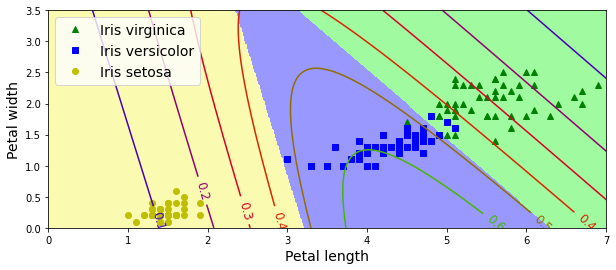

In [38]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

이제 테스트 세트에 대한 모델의 최종 정확도를 측정해 보겠습니다:

In [39]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333

완벽했던 최종 모델의 성능이 조금 떨어졌습니다. 이런 차이는 데이터셋이 작기 때문일 것입니다. 

훈련 세트와 검증 세트, 테스트 세트를 어떻게 샘플링했는지에 따라 매우 다른 결과를 얻을 수 있습니다. 

몇 번 랜덤 시드를 바꾸고 이 코드를 다시 실행해 보면 결과가 달라지는 것을 확인할 수 있습니다.